In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import re
import time
import copy as cp
import argparse
import toml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
import pandas as pd
import zeus

from scipy.interpolate import PchipInterpolator, CubicSpline

import alfred.utils as utils
import alfred.emulator as emulator
import alfred.KSZ as KSZ
import alfred.peefit as peefit
import alfred.surveys as surveys

import joblib
import keras
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import warnings
from types import SimpleNamespace
from scipy.interpolate import RegularGridInterpolator, RectBivariateSpline
from catwoman.shelter import Cat

import alfred.surveys as surveys
import alfred.emulator as emulator
import alfred.utils as utils
from alfred.parameters import *
from alfred.astrofit import *

2025-10-01 13:52:19.096577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759319539.129784 2566730 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759319539.137504 2566730 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759319539.158626 2566730 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759319539.158662 2566730 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759319539.158664 2566730 computation_placer.cc:177] computation placer alr

parsing /data/cluster/emc-brid/Datasets/LoReLi/spectra/kSZ/LoReLi/nells30_v5 ...
6797 sims available
Now on 0 run...
Now on 1 run...
Now on 2 run...
Now on 3 run...
Now on 4 run...


# Introduction to LoReLi

This notebook walks you through accessing the LoReLi database, from parsing the simulation metadata to loading simulation field cubes.

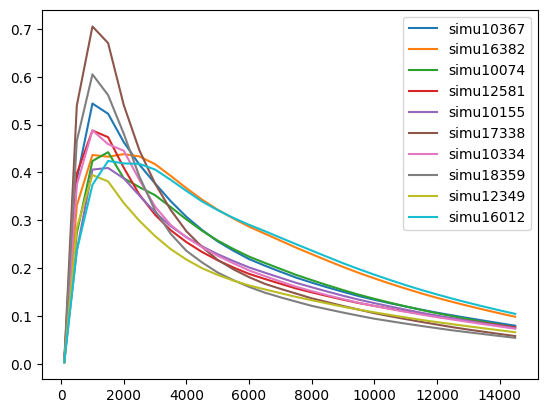

In [9]:
sns = df.sample(n=10).index

for sn in sns:
    plt.plot(ells, utils.spectra(sn), label=f"simu{sn}")

plt.legend()

In [3]:
df.loc['12091']

fX     -2.050181
rHS     0.600000
tau     3.186730
Mmin    9.330000
fesc    0.275000
Name: 12091, dtype: float64

In [22]:
sim = Cat('18886',
    skip_early=True,
    path_spectra='ps_ee',
    path_sim='/data/cluster/emc-brid/Datasets/LoReLi/simcubes',
    base_dir=base_dir,
    load_spectra=False,
    load_density_cubes=True,
    load_xion_cubes=True,
    load_21cm_cubes=True,
    verbose=False)

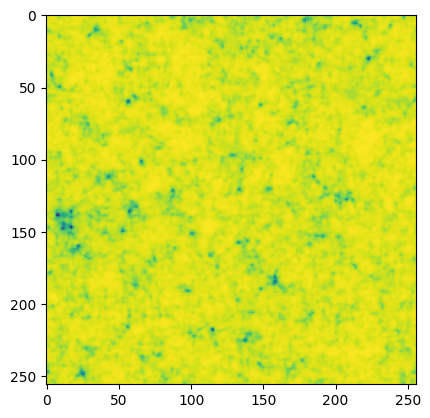

In [18]:
plt.imshow(sim.T21cm[0]['cube'][0,:,:])

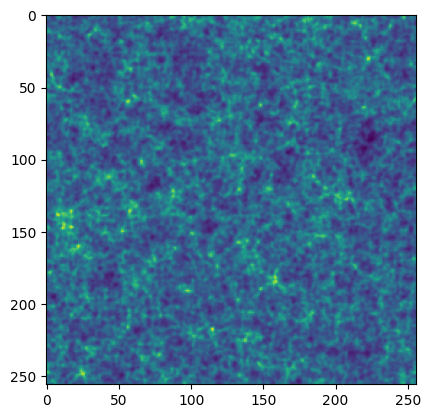

In [19]:
plt.imshow(sim.density[0]['cube'][0,:,:])